# Loan Default Prediction

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
from sklearn.metrics import recall_score, classification_report, confusion_matrix, make_scorer, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_csv('Loan_Default.csv')
data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [4]:
data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [5]:
data.shape

(148670, 34)

In [6]:
data.nunique() # number of unique values in each column

ID                           148670
year                              1
loan_limit                        2
Gender                            4
approv_in_adv                     2
loan_type                         3
loan_purpose                      4
Credit_Worthiness                 2
open_credit                       2
business_or_commercial            2
loan_amount                     211
rate_of_interest                131
Interest_rate_spread          22516
Upfront_charges               58271
term                             26
Neg_ammortization                 2
interest_only                     2
lump_sum_payment                  2
property_value                  385
construction_type                 2
occupancy_type                    3
Secured_by                        2
total_units                       4
income                         1001
credit_type                       4
Credit_Score                    401
co-applicant_credit_type          2
age                         

In [7]:
data[data.duplicated()] # no duplicated data

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1


In [8]:
data.isnull().sum()

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

There are a lot of null values in some of the columns. The first approach tried was to remove all the rows that has null values, however, it led to a slimmer '1' resulted target data which will cause problems while training. So, instead of changing distribution of the target, null values should be filled appropriately.

In [9]:
for i in data.columns:       
    if data[i].dtype=='float64' or data[i].dtype=='int64': # if numerical, fill with mean
        data[i].fillna(data[i].mean(),inplace=True)

    else:
        data[i].fillna(data[i].mode()[0],inplace=True) # if categorical, fill with mode

data.isnull().sum()

ID                           0
year                         0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Type                0
Status  

## EDA

In [10]:
# Let's drop the columns that does not provide any information
# ID: unique for each user
# year: same for all users (2019)
# dtir1: data leakage since it is the probability of default

data.drop(['ID', 'year', 'dtir1'], axis=1, inplace=True)
data.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,4.045476,...,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,4.045476,...,4980.0,EQUI,552,EXP,55-64,to_inst,72.746457,North,direct,1
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.560000,...,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.250000,...,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.000000,...,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0


In [11]:
categorical_data = data.select_dtypes("object")
numeric_data = data.select_dtypes(exclude=["object"])

In [12]:
print("Number of categorical features:", categorical_data.shape[1])
print("Number of numerical features:", numeric_data.shape[1])

Number of categorical features: 21
Number of numerical features: 10


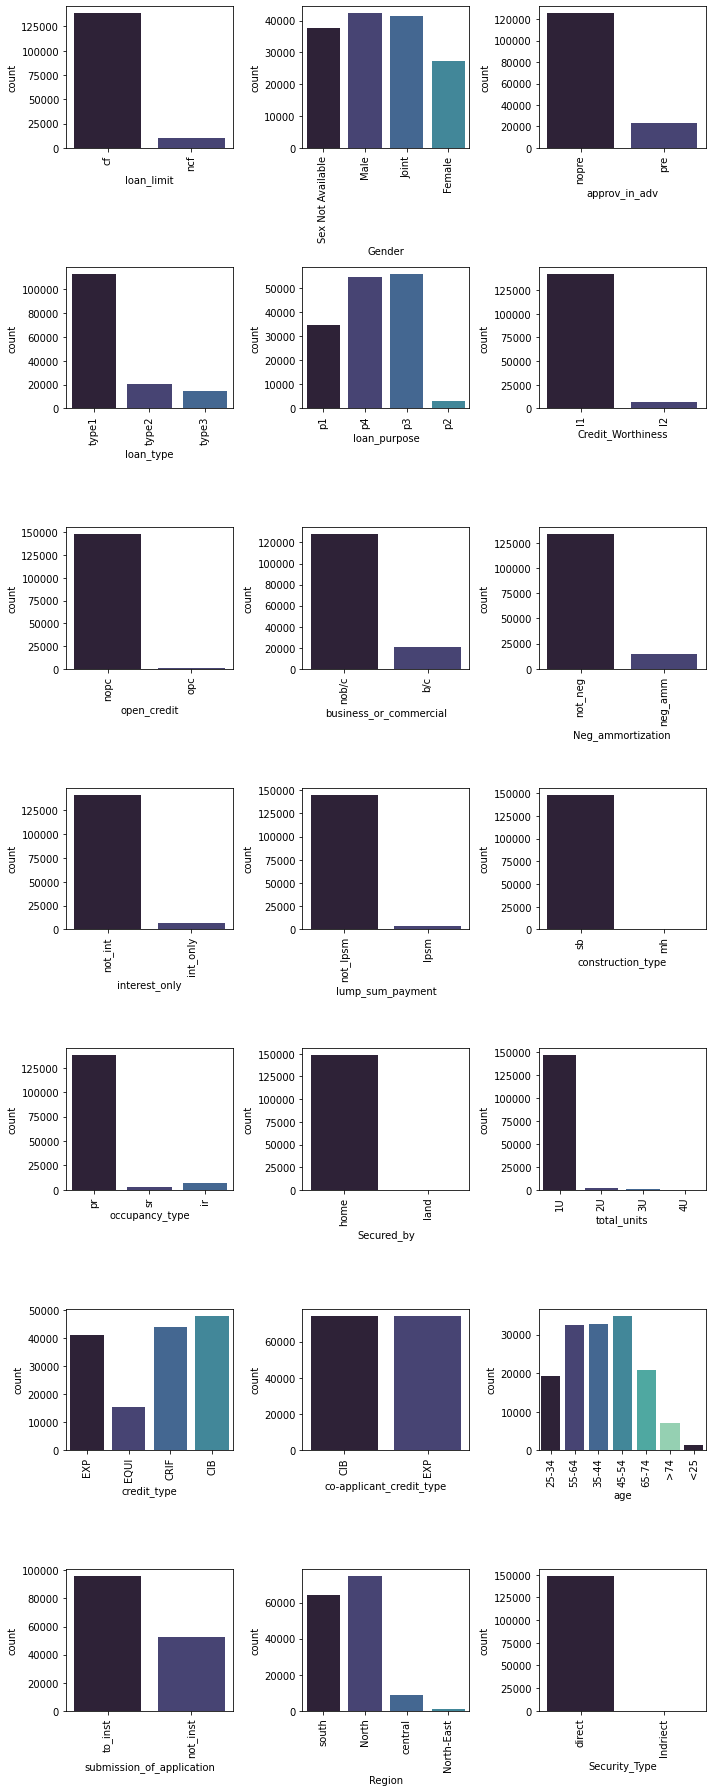

In [13]:
fig, axes = plt.subplots(7, 3)
fig.set_figheight(25)
fig.set_figwidth(10)

for i in range(len(categorical_data.columns)):
    row = i // 3
    col = i % 3
    plot = sns.countplot(data=categorical_data, x=categorical_data.columns[i], palette=sns.color_palette("mako"), ax=axes[row, col])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

for j in range(i + 1, 7 * 3):
    fig.delaxes(axes[j // 3, j % 3])

fig.tight_layout()
plt.show()

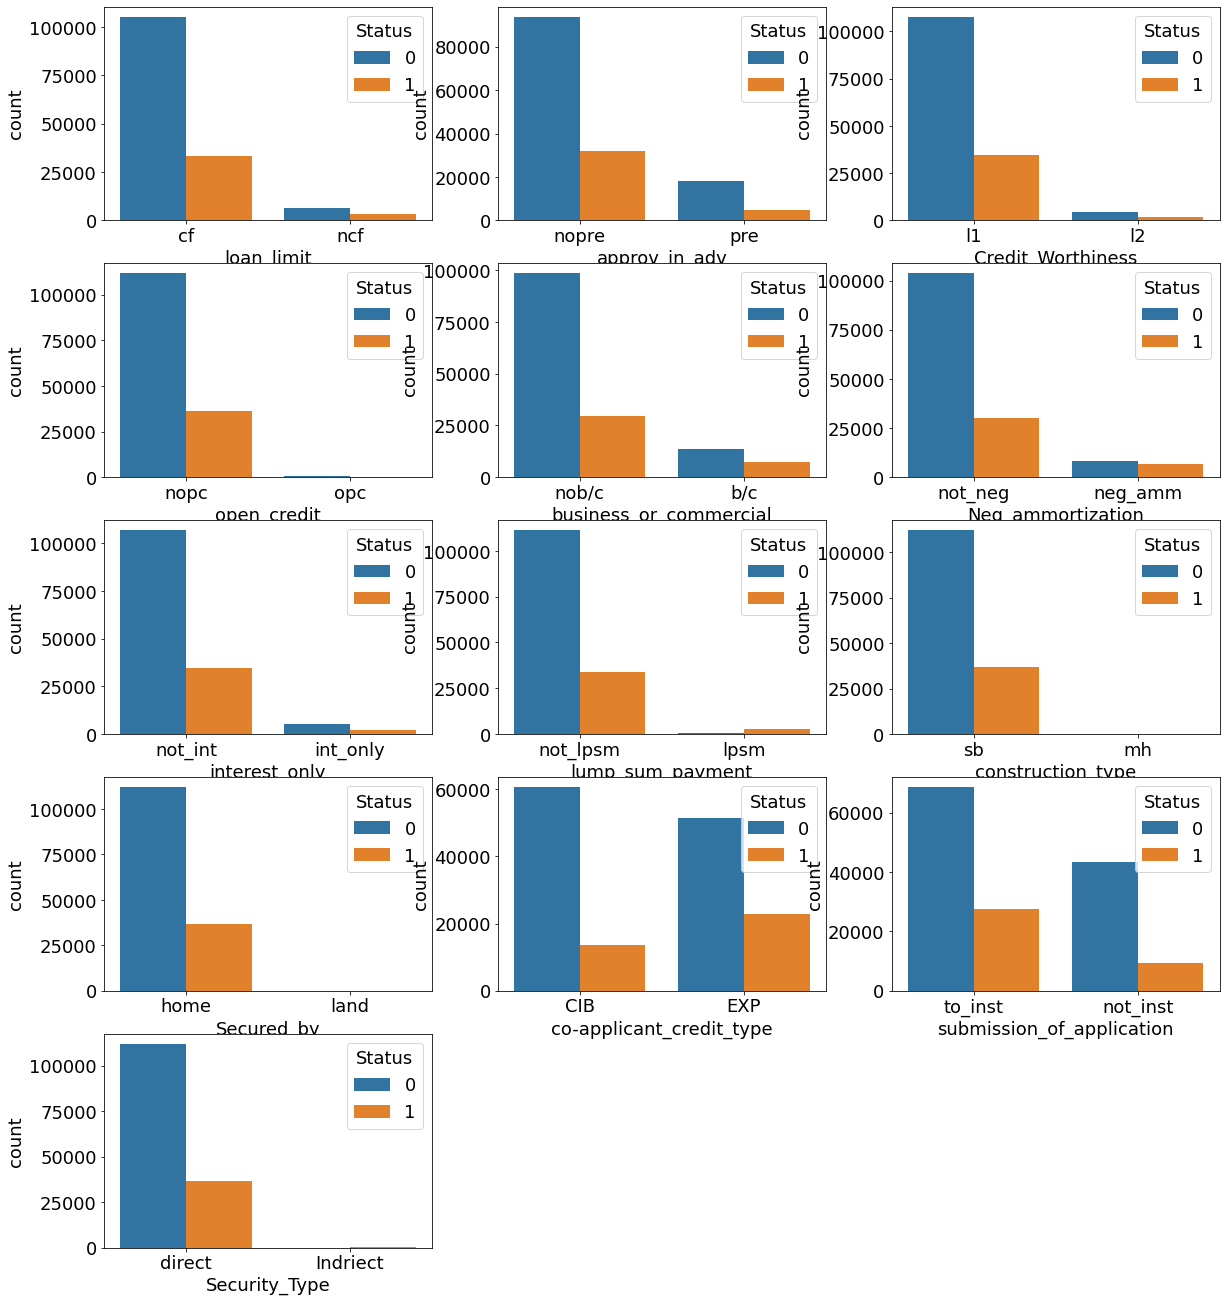

In [14]:
binary_columns = [col for col in data.columns if data[col].nunique() == 2]
binary_columns.remove('Status')

def countPlot(columns):
  plt.rcParams['font.size'] = 18
  fig = plt.figure(figsize=(20,37))
  for i,txt in enumerate(columns):
    ax = fig.add_subplot(8,3,i+1)
    sns.countplot(x=data[txt], ax=ax, hue=data['Status'])
  plt.show()

countPlot(binary_columns)

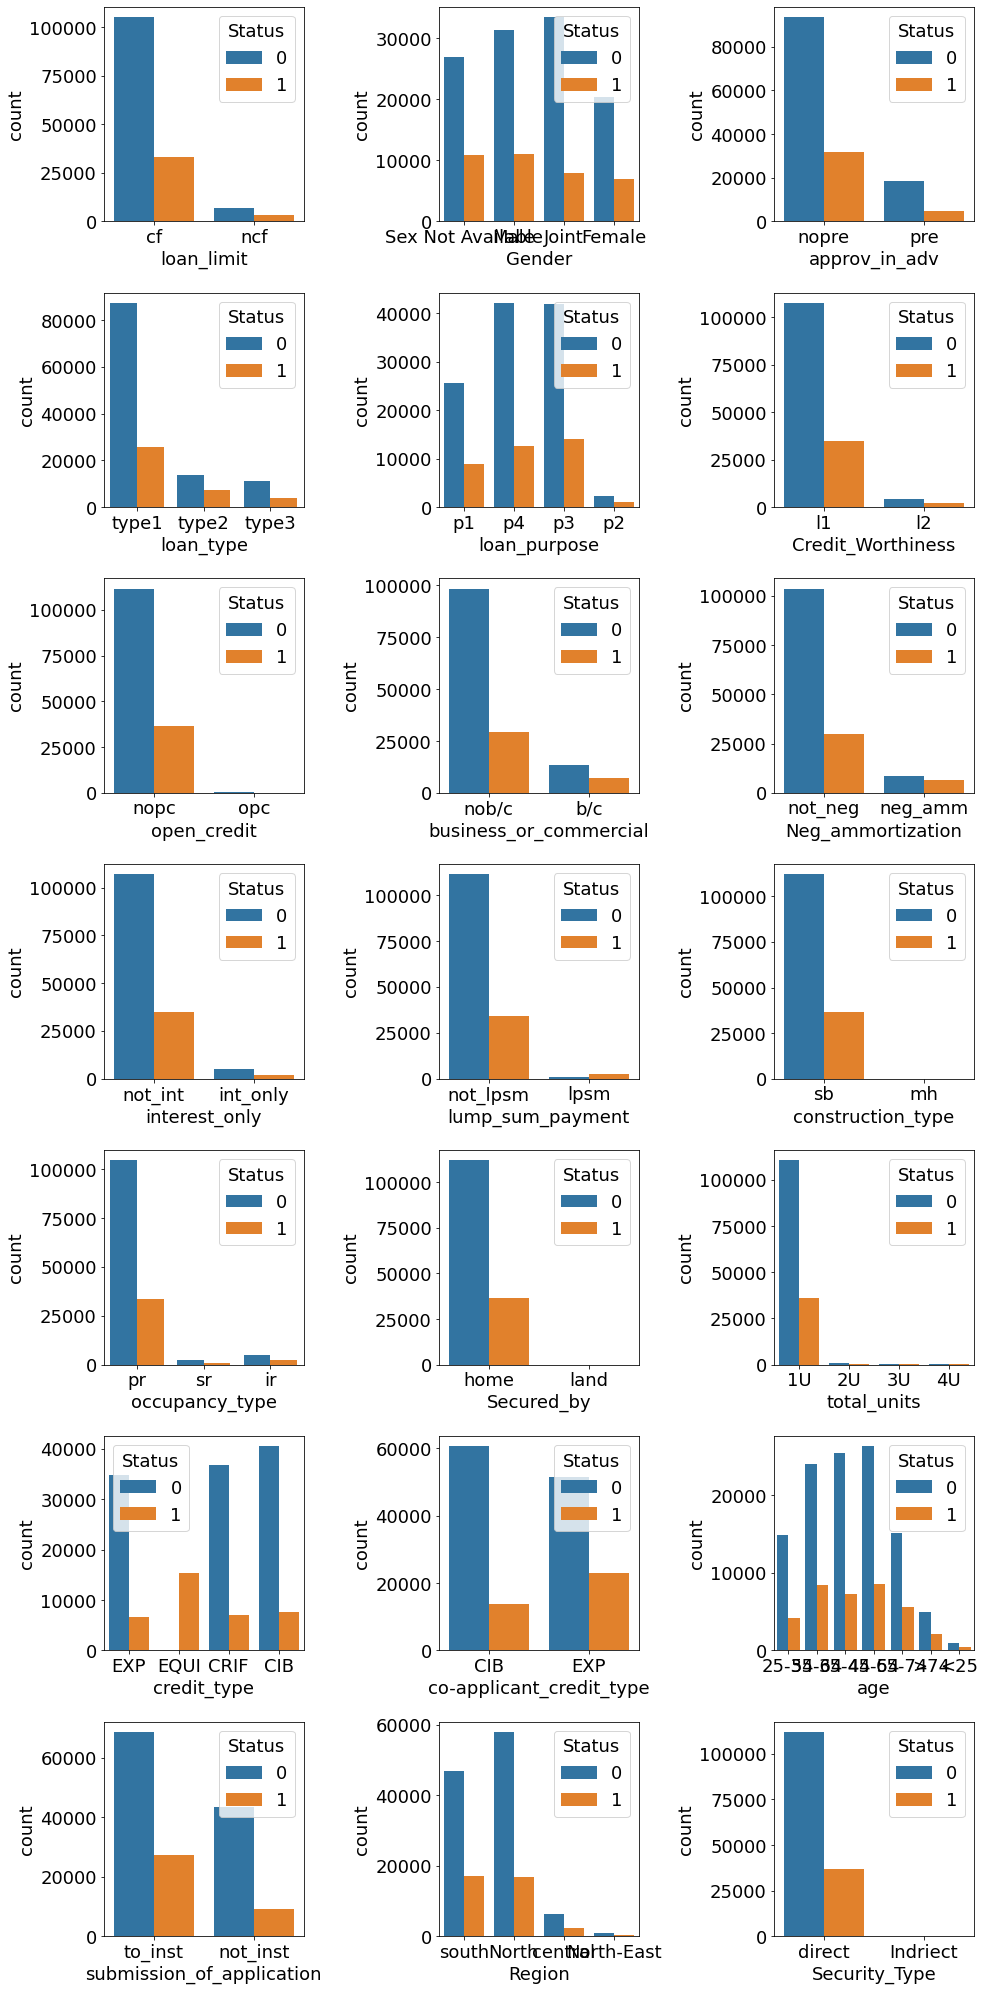

In [15]:
categorical_features = data.select_dtypes(include=object).columns

def catPlot(categorical_features, data):
    n = len(categorical_features)
    cols = 3 
    rows = (n + cols - 1) // cols 
    plt.rcParams['font.size'] = 18
    fig = plt.figure(figsize=(14, 4 * rows))
    for i, txt in enumerate(categorical_features):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.countplot(x=data[txt], ax=ax, hue=data['Status'])
    plt.tight_layout()
    plt.show()

catPlot(categorical_features, data)

As it can be seen here, no columns has a single value, but the two valued ones are very unbalanced. The data is high dimensional which might cause problems going further. In this case some of the columns with too few values can be dropped. It should be checked if the column might be helpful with predicting target data by checking if most of the positive values are yielded into the minority value of the column which did not for any columns case.

In [16]:
data.drop(['loan_limit', 'Credit_Worthiness', 'open_credit', 'interest_only', 'lump_sum_payment', 'construction_type', 'Secured_by', 'total_units', 'Security_Type'], axis=1, inplace=True)

In [17]:
for col in categorical_data.columns:
    print(categorical_data[col].value_counts() , "\n")

cf     138692
ncf      9978
Name: loan_limit, dtype: int64 

Male                 42346
Joint                41399
Sex Not Available    37659
Female               27266
Name: Gender, dtype: int64 

nopre    125529
pre       23141
Name: approv_in_adv, dtype: int64 

type1    113173
type2     20762
type3     14735
Name: loan_type, dtype: int64 

p3    56068
p4    54799
p1    34529
p2     3274
Name: loan_purpose, dtype: int64 

l1    142344
l2      6326
Name: Credit_Worthiness, dtype: int64 

nopc    148114
opc        556
Name: open_credit, dtype: int64 

nob/c    127908
b/c       20762
Name: business_or_commercial, dtype: int64 

not_neg    133541
neg_amm     15129
Name: Neg_ammortization, dtype: int64 

not_int     141560
int_only      7110
Name: interest_only, dtype: int64 

not_lpsm    145286
lpsm          3384
Name: lump_sum_payment, dtype: int64 

sb    148637
mh        33
Name: construction_type, dtype: int64 

pr    138201
ir      7340
sr      3129
Name: occupancy_type, dtype: int

In [18]:
numeric_data.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status
0,116500,4.045476,0.441656,3224.996127,360.0,118000.000000,1740.0,758,98.728814,1
1,206500,4.045476,0.441656,3224.996127,360.0,497893.465696,4980.0,552,72.746457,1
2,406500,4.560000,0.200000,595.000000,360.0,508000.000000,9480.0,834,80.019685,0
3,456500,4.250000,0.681000,3224.996127,360.0,658000.000000,11880.0,587,69.376900,0
4,696500,4.000000,0.304200,0.000000,360.0,758000.000000,10440.0,602,91.886544,0


In [19]:
numeric_data.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status
count,1.486700e+05,148670.000000,148670.000000,148670.000000,148670.000000,1.486700e+05,148670.000000,148670.000000,148670.000000,148670.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445
std,1.839093e+05,0.487764,0.445359,2784.133285,58.401029,3.411696e+05,6293.492004,115.875857,37.883839,0.430942
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000
25%,1.965000e+05,3.750000,0.181500,1250.000000,360.000000,2.880000e+05,3840.000000,599.000000,63.297872,0.000000
50%,2.965000e+05,4.045476,0.441656,3224.996127,360.000000,4.580000e+05,6000.000000,699.000000,73.026316,0.000000
75%,4.365000e+05,4.250000,0.620000,3889.495000,360.000000,5.980000e+05,8280.000000,800.000000,84.722222,0.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000


In [20]:
one_valued_cols = [col for col in numeric_data.columns if numeric_data[col].nunique() == 1]
one_valued_cols

[]

No single valued numerical column.

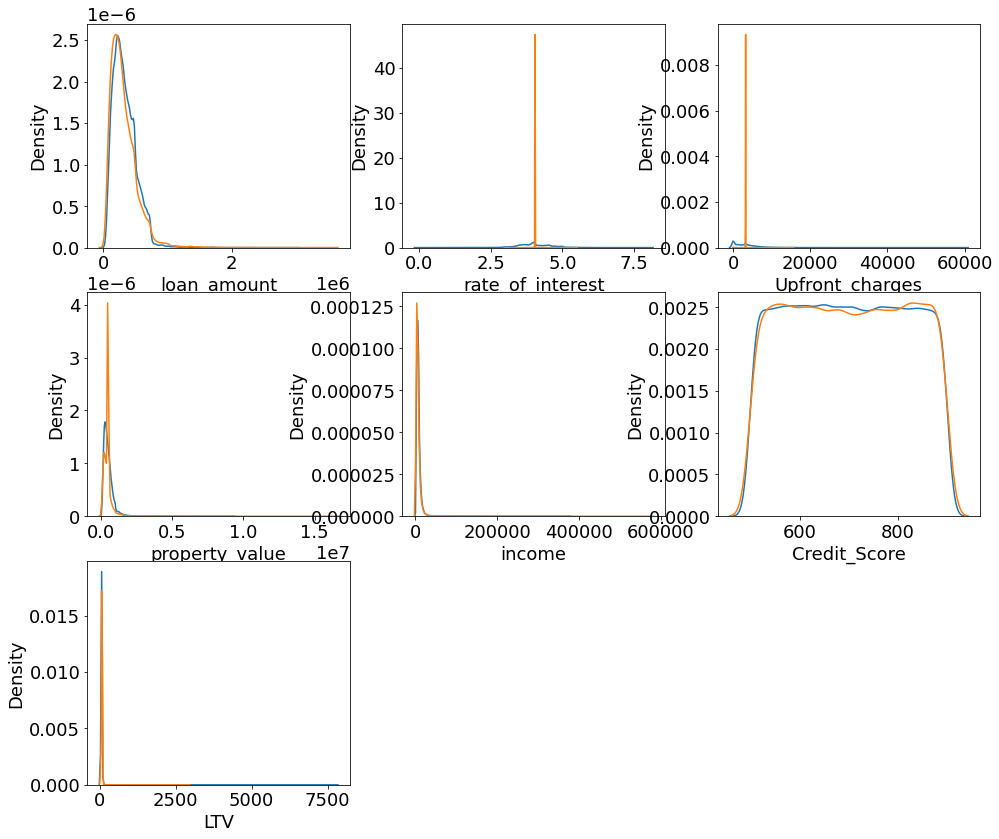

In [21]:
continuous_values = ['loan_amount','rate_of_interest','Upfront_charges','property_value','income', 'Credit_Score', 'LTV']

def densityPlot(continuous_values, data):
    fig = plt.figure(figsize=(16,14))
    for i, txt in enumerate(continuous_values):
        ax = fig.add_subplot(3, 3, i+1)
        sns.kdeplot(data.loc[data['Status'] == 0, txt], ax=ax, label='Status==0')
        sns.kdeplot(data.loc[data['Status'] == 1, txt], ax=ax, label='Status==1')
    plt.show()

densityPlot(continuous_values, data)

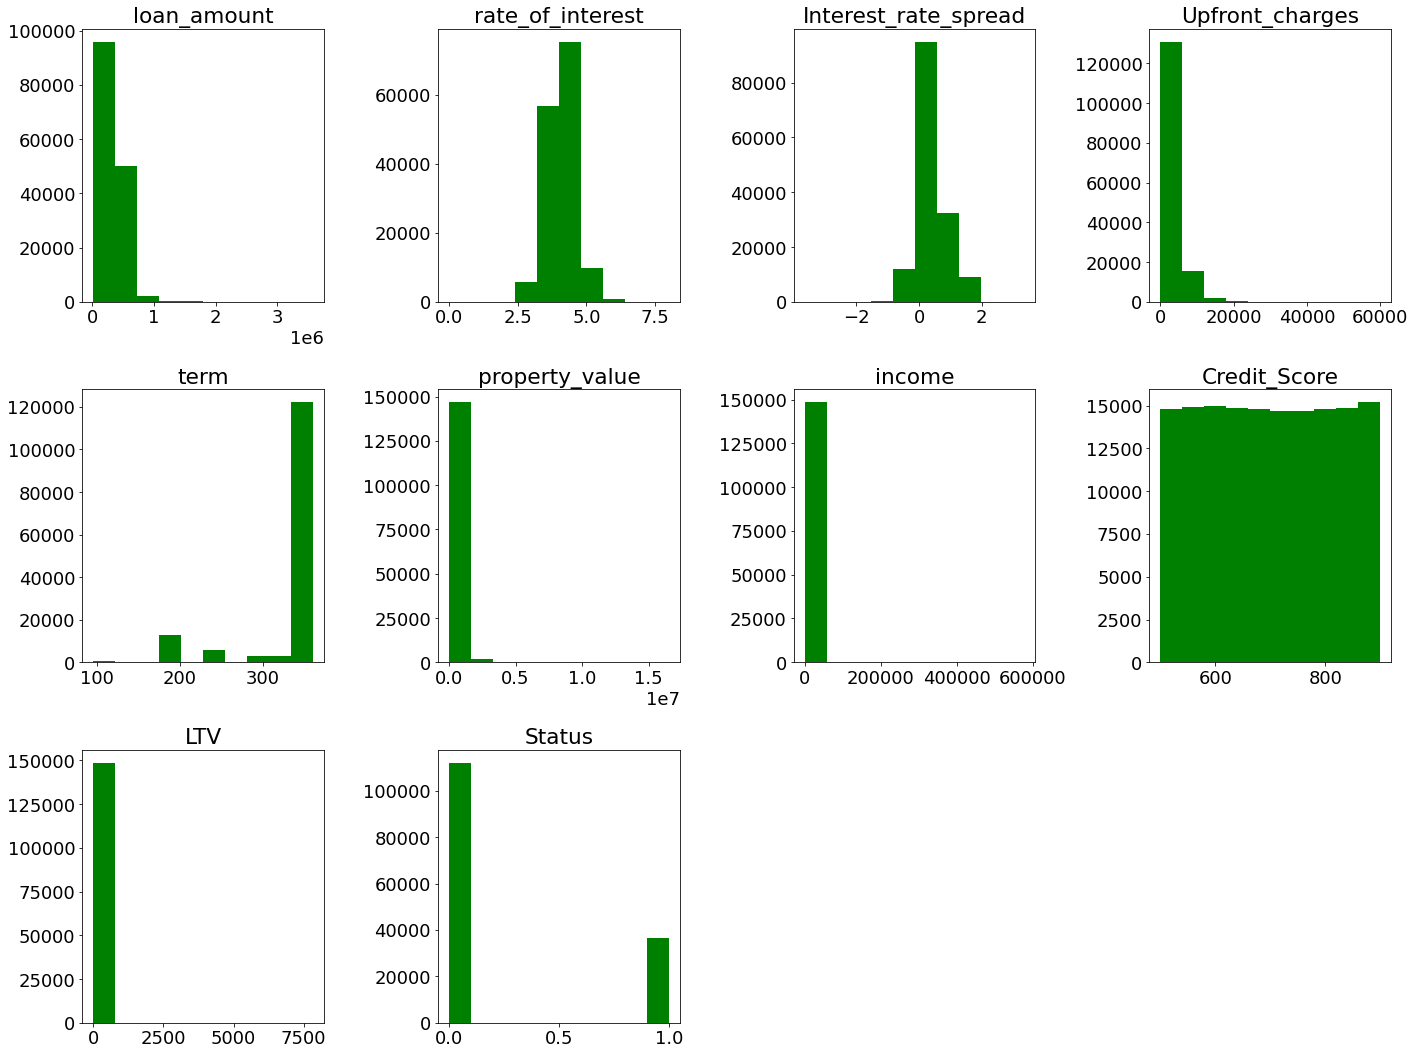

In [22]:
figure, axis = plt.subplots(3, 4) 
figure.set_figheight(15) 
figure.set_figwidth(20) 

for n in range(len(numeric_data.columns)):
    col = n % 4
    row = n // 4
    axis[row, col].hist(numeric_data[numeric_data.columns[n]], color="green", lw=0)
    axis[row, col].title.set_text(numeric_data.columns[n])

for n in range(len(numeric_data.columns), 3 * 4):
    figure.delaxes(axis[n // 4, n % 4])

figure.tight_layout()
plt.show()

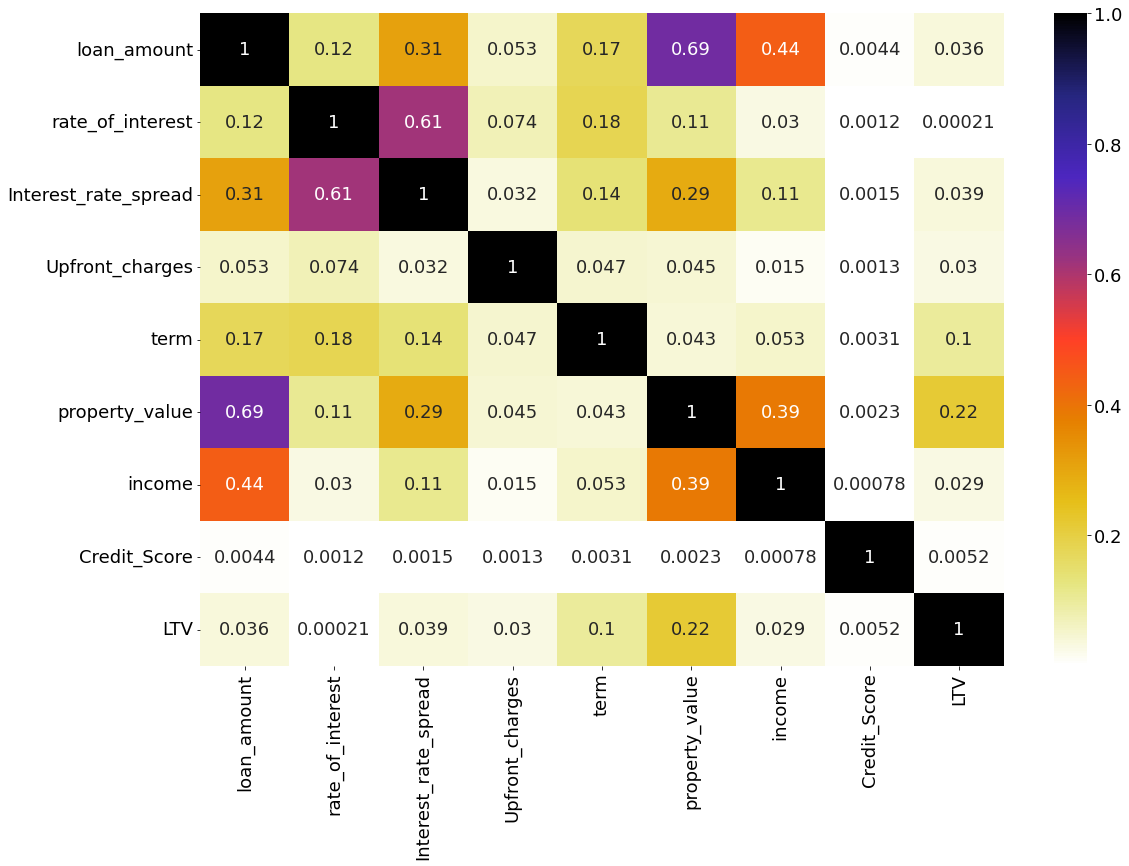

In [23]:
y = data["Status"]
X = numeric_data.drop(['Status'] , axis=1)
pearson_corr = X.corr().abs()
plt.figure(figsize=(18,12))
sns.heatmap(pearson_corr , cmap=plt.cm.CMRmap_r , annot=True)
plt.show()

It is obvious that some columns may correlate to each other in context. The 'interest rate' and the 'interest spread' can be obtained from one another so they are not needed at the same time.  
Also 'loan amount', 'property value', and 'income' correlates highly as expected. Thus, one of them is enough.

In [24]:
data.drop(['Interest_rate_spread', 'property_value', 'income'], axis=1, inplace=True)
numeric_data = data.select_dtypes(exclude=["object"]) # update numeric data

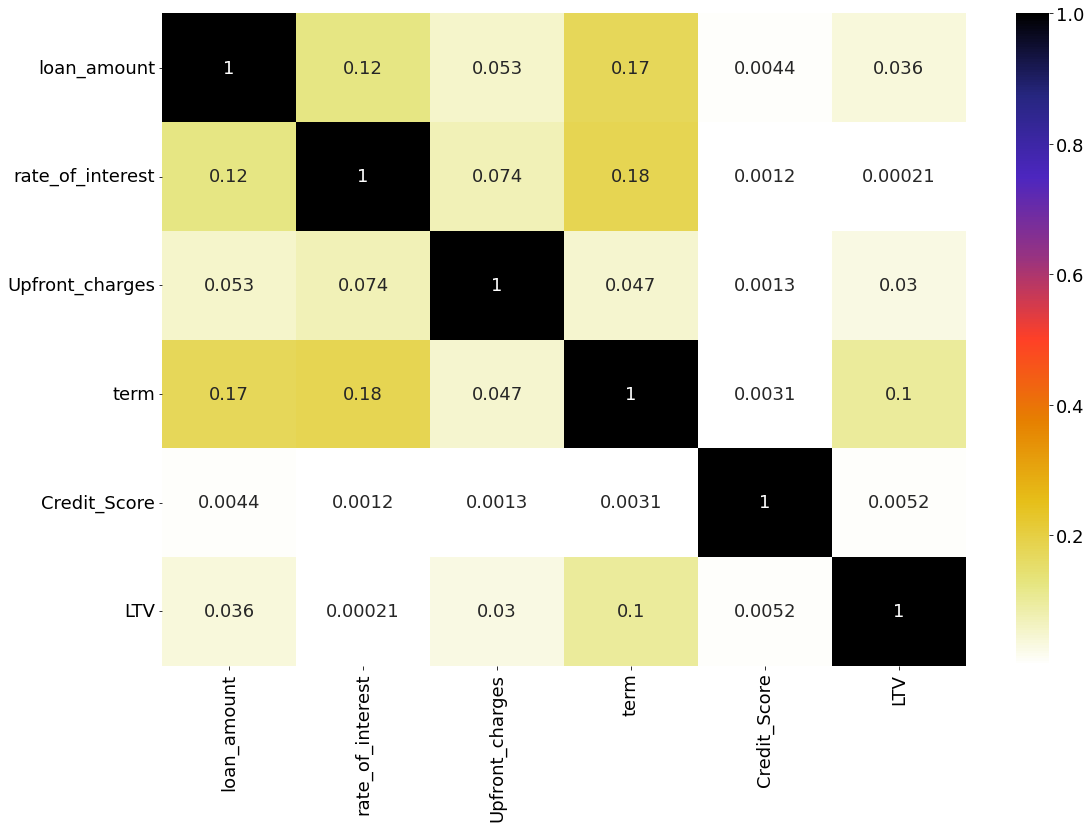

In [25]:
y = data["Status"]
X = numeric_data.drop(['Status'] , axis=1)
pearson_corr = X.corr().abs()
plt.figure(figsize=(18,12))
sns.heatmap(pearson_corr , cmap=plt.cm.CMRmap_r , annot=True)
plt.show()

## Pre-processing the Data

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Gender                     148670 non-null  object 
 1   approv_in_adv              148670 non-null  object 
 2   loan_type                  148670 non-null  object 
 3   loan_purpose               148670 non-null  object 
 4   business_or_commercial     148670 non-null  object 
 5   loan_amount                148670 non-null  int64  
 6   rate_of_interest           148670 non-null  float64
 7   Upfront_charges            148670 non-null  float64
 8   term                       148670 non-null  float64
 9   Neg_ammortization          148670 non-null  object 
 10  occupancy_type             148670 non-null  object 
 11  credit_type                148670 non-null  object 
 12  Credit_Score               148670 non-null  int64  
 13  co-applicant_credit_type   14

Categorical (object) data should be converted to numerical for training.

In [27]:
categorical_features = data.select_dtypes(include="object").columns
label_encoder = preprocessing.LabelEncoder()
for i in range(len(categorical_features)):
    data[categorical_features[i]] = label_encoder.fit_transform(data[categorical_features[i]].astype(str))
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Gender                     148670 non-null  int32  
 1   approv_in_adv              148670 non-null  int32  
 2   loan_type                  148670 non-null  int32  
 3   loan_purpose               148670 non-null  int32  
 4   business_or_commercial     148670 non-null  int32  
 5   loan_amount                148670 non-null  int64  
 6   rate_of_interest           148670 non-null  float64
 7   Upfront_charges            148670 non-null  float64
 8   term                       148670 non-null  float64
 9   Neg_ammortization          148670 non-null  int32  
 10  occupancy_type             148670 non-null  int32  
 11  credit_type                148670 non-null  int32  
 12  Credit_Score               148670 non-null  int64  
 13  co-applicant_credit_type   14

In [28]:
data.groupby("Status").count()

,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Upfront_charges,term,Neg_ammortization,occupancy_type,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region
Status,,,,,,,,,,,,,,,,,,
0,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031,112031
1,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639,36639


In [29]:
categorical_features = data.select_dtypes(include="object").columns
label_encoder = preprocessing.LabelEncoder()
for i in range(len(categorical_features)):
    data[categorical_features[i]] = label_encoder.fit_transform(data[categorical_features[i]].astype(str))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Gender                     148670 non-null  int32  
 1   approv_in_adv              148670 non-null  int32  
 2   loan_type                  148670 non-null  int32  
 3   loan_purpose               148670 non-null  int32  
 4   business_or_commercial     148670 non-null  int32  
 5   loan_amount                148670 non-null  int64  
 6   rate_of_interest           148670 non-null  float64
 7   Upfront_charges            148670 non-null  float64
 8   term                       148670 non-null  float64
 9   Neg_ammortization          148670 non-null  int32  
 10  occupancy_type             148670 non-null  int32  
 11  credit_type                148670 non-null  int32  
 12  Credit_Score               148670 non-null  int64  
 13  co-applicant_credit_type   14

In [30]:
data.head()

,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Upfront_charges,term,Neg_ammortization,occupancy_type,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Status
0,3,0,0,0,1,116500,4.045476,3224.996127,360.0,1,1,3,758,0,0,1,98.728814,3,1
1,2,0,1,0,0,206500,4.045476,3224.996127,360.0,1,1,2,552,1,3,1,72.746457,0,1
2,2,1,0,0,1,406500,4.560000,595.000000,360.0,0,1,3,834,0,1,1,80.019685,3,0
3,2,0,0,3,1,456500,4.250000,3224.996127,360.0,1,1,3,587,0,2,0,69.376900,0,0
4,1,1,0,0,1,696500,4.000000,0.000000,360.0,1,1,1,602,1,0,0,91.886544,0,0


### Standardizing and Splitting Data into Train and Test Sets

In [31]:
def get_train_test(data):
    df_copy = data.copy()
    scale = StandardScaler()
    X = df_copy.drop(["Status"] , axis=1)
    y = data["Status"]
    X_train , X_test , y_train , y_test = train_test_split(X , y , train_size=0.8)
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    X_train = pd.DataFrame(X_train, columns = X.columns)
    X_test = pd.DataFrame(X_test, columns = X.columns)
    return X_train , X_test , y_train , y_test

In [32]:
X_train , X_test , y_train , y_test = get_train_test(data)

In [33]:
X_train.head()

,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Upfront_charges,term,Neg_ammortization,occupancy_type,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region
0,-1.525058,-0.429635,2.556723,0.103984,0.402105,-0.622748,0.000177,-0.000573,0.427205,-2.977877,0.108351,0.558277,-1.034557,1.002492,1.158788,0.741169,-0.000496,-0.977226
1,1.317896,-0.429635,1.018385,0.103984,-2.486911,-1.383331,0.000177,-0.000573,0.427205,0.335810,0.108351,-0.278987,-1.328110,-0.997514,1.158788,0.741169,0.342176,1.088206
2,0.370245,-0.429635,-0.519954,0.103984,0.402105,0.789763,-0.862071,-0.695277,0.427205,0.335810,0.108351,1.395541,-0.775539,-0.997514,0.500183,-1.349220,-0.239254,-0.977226
3,-0.577406,-0.429635,-0.519954,0.979055,0.402105,0.952745,0.675914,-1.158839,0.427205,0.335810,0.108351,-1.116251,0.588620,1.002492,0.500183,-1.349220,-0.122067,-0.977226
4,-1.525058,-0.429635,-0.519954,-1.646159,0.402105,1.278709,-0.113585,-1.158839,0.427205,0.335810,0.108351,-1.116251,0.277799,-0.997514,-0.158422,-1.349220,0.290808,1.088206


In [34]:
X_test.head()

,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Upfront_charges,term,Neg_ammortization,occupancy_type,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region
0,-1.525058,-0.429635,1.018385,0.103984,-2.486911,0.409471,-1.118402,-1.158839,0.427205,-2.977877,0.108351,-1.116251,0.674959,-0.997514,0.500183,-1.349220,0.296520,-0.977226
1,1.317896,-0.429635,-0.519954,-1.646159,0.402105,-0.568421,0.000177,-0.000573,0.427205,0.335810,0.108351,0.558277,-1.526690,1.002492,-0.158422,0.741169,-0.000496,1.088206
2,1.317896,2.327558,-0.519954,0.979055,0.402105,6.113843,0.000177,-0.000573,0.427205,0.335810,0.108351,0.558277,-1.630297,1.002492,-1.475632,0.741169,-0.000496,1.088206
3,0.370245,-0.429635,-0.519954,0.979055,0.402105,-0.025147,0.000177,-0.000573,0.427205,0.335810,0.108351,0.558277,0.295067,1.002492,-0.817027,-1.349220,-0.000496,-0.977226
4,-0.577406,-0.429635,-0.519954,-1.646159,0.402105,0.626781,0.000177,-0.000573,0.427205,0.335810,0.108351,-1.116251,0.485013,1.002492,-0.817027,-1.349220,0.141127,1.088206


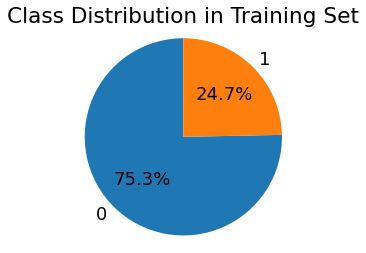

In [35]:
# Distribution of quality values in the training set
unique, count = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, count))

fig, ax = plt.subplots()
ax.pie(count, labels=unique, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Class Distribution in Training Set')
plt.show()

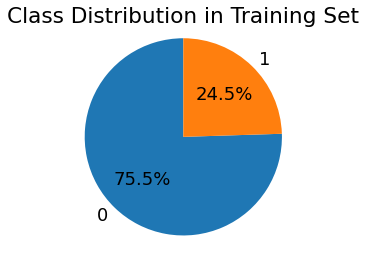

In [36]:
# Distribution of quality values in the test set
unique, count = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, count))

fig, ax = plt.subplots()
ax.pie(count, labels=unique, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Class Distribution in Training Set')
plt.show()

The distribution of the target value in train and test sets which is 1/3 for both. However, it looks like the data is very unbalanced minoring in positive (1) data. 

## Training Models

In [37]:
cross_validation = KFold(n_splits=5 , shuffle=True)

### Naive Bayes

In [38]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

cross_validation = KFold(n_splits=5 , shuffle=True)
accuracy_gnb = cross_val_score(gnb , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_gnb = cross_val_score(gnb , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_gnb = cross_val_score(gnb , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_gnb = cross_val_score(gnb , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_gnb = cross_val_score(gnb , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_gnb = pd.DataFrame({
    "Accuracy" : accuracy_gnb, 
    "Precision": precision_gnb,
    "Recall" : recall_gnb, 
    "f1 Score" : f1_gnb,
    "ROC AUC" : roc_auc_gnb
})

result_gnb

,Accuracy,Precision,Recall,f1 Score,ROC AUC
0,0.976291,0.916208,0.993761,0.947776,0.994419
1,0.976920,0.912783,0.993484,0.953836,0.993655
2,0.975281,0.918192,0.994601,0.953973,0.994810
3,0.977256,0.916433,0.986266,0.953583,0.994592
4,0.973935,0.915227,0.995548,0.956679,0.994855


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     22449
           1       0.92      0.99      0.95      7285

    accuracy                           0.98     29734
   macro avg       0.96      0.98      0.97     29734
weighted avg       0.98      0.98      0.98     29734



Text(83.68, 0.5, 'True Labels')

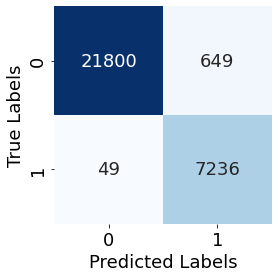

In [39]:
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

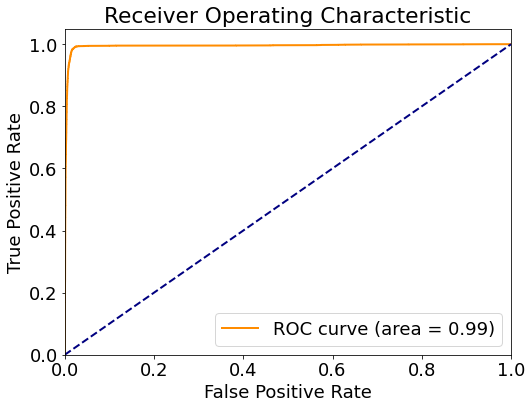

In [40]:
y_probs = gnb.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

In [41]:
logistic_regression = LogisticRegression(dual=False , random_state = 12345, max_iter=1000)
logistic_regression.fit(X_train , y_train)

accuracy_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_logistic_reg = pd.DataFrame({
    "Accuracy" : accuracy_lr, 
    "Precision": precision_lr,
    "Recall" : recall_lr, 
    "f1Score" : f1_lr,
    "ROCAUC" : roc_auc_lr
})

result_logistic_reg

,Accuracy,Precision,Recall,f1Score,ROCAUC
0,0.760467,0.580944,0.108747,0.180020,0.693811
1,0.760668,0.571178,0.112100,0.179032,0.690422
2,0.758187,0.585975,0.106351,0.187617,0.684932
3,0.756548,0.567718,0.106553,0.181636,0.685186
4,0.763821,0.568595,0.108113,0.180528,0.694366


              precision    recall  f1-score   support

           0       0.77      0.97      0.86     22449
           1       0.57      0.11      0.19      7285

    accuracy                           0.76     29734
   macro avg       0.67      0.54      0.52     29734
weighted avg       0.72      0.76      0.70     29734



Text(83.68, 0.5, 'True Labels')

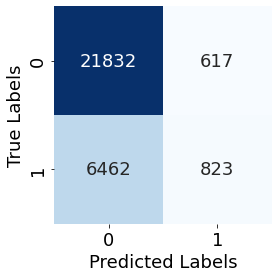

In [42]:
y_pred = logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

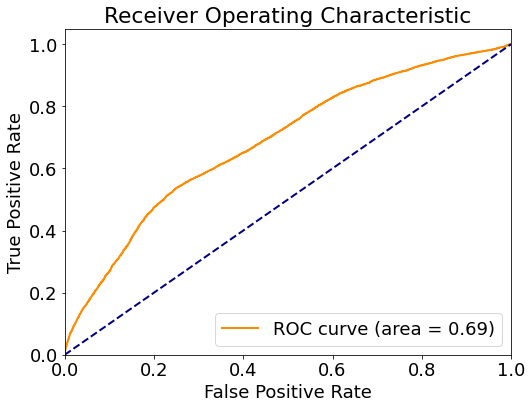

In [43]:
y_probs = logistic_regression.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

It is obvious that some models might struggle with predicting the positives since the data is very imbalanced. Let's test the models which works good with the available data (Naive Bayes) and which is not doing very good with the minority class (Logistic Regression) using balanced data to decide whether this process is necessary.

## Working with Balanced Data

0    112031
1     36639
Name: Status, dtype: int64


<AxesSubplot:ylabel='Type'>

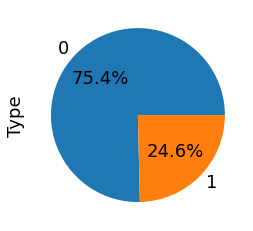

In [44]:
print(data["Status"].value_counts())

data.groupby("Status").size().plot(kind='pie',
                                       y = "Status",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [45]:
default = data[data["Status"] == 1]
not_def  = data[data["Status"] == 0]
default.shape, not_def.shape

((36639, 19), (112031, 19))

In [46]:
not_def_downsample = resample(not_def,
             replace=True,
             n_samples=len(default),
             random_state=42)

print(not_def_downsample.shape)

(36639, 19)


0    36639
1    36639
Name: Status, dtype: int64


<AxesSubplot:ylabel='Type'>

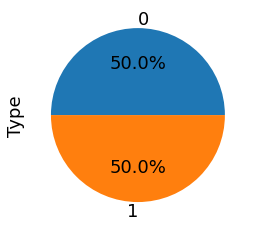

In [47]:
data_downsampled = pd.concat([not_def_downsample, default])

print(data_downsampled["Status"].value_counts())

data_downsampled.groupby('Status').size().plot(kind='pie',
                                       y = "Status",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [48]:
X_train, X_test, y_train, y_test = get_train_test(data_downsampled)

### Naive Bayes

In [49]:
gnb_ds = GaussianNB()
gnb_ds.fit(X_train, y_train)

cross_validation = KFold(n_splits=5 , shuffle=True)
accuracy_gnb_ds = cross_val_score(gnb_ds , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_gnb_ds = cross_val_score(gnb_ds , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_gnb_ds = cross_val_score(gnb_ds , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_gnb_ds = cross_val_score(gnb_ds , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_gnb_ds = cross_val_score(gnb_ds , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_gnb_ds = pd.DataFrame({
    "Accuracy" : accuracy_gnb_ds, 
    "Precision": precision_gnb_ds,
    "Recall" : recall_gnb_ds, 
    "f1 Score" : f1_gnb_ds,
    "ROC AUC" : roc_auc_gnb_ds
})

result_gnb_ds

,Accuracy,Precision,Recall,f1 Score,ROC AUC
0,0.979531,0.963648,0.993201,0.980559,0.994178
1,0.978934,0.970196,0.995068,0.978982,0.994860
2,0.979103,0.966986,0.995635,0.982698,0.993531
3,0.982344,0.972482,0.992675,0.979568,0.994065
4,0.981320,0.966088,0.991630,0.980066,0.994156


              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7460
           1       0.96      0.99      0.98      7196

    accuracy                           0.98     14656
   macro avg       0.98      0.98      0.98     14656
weighted avg       0.98      0.98      0.98     14656



Text(83.68, 0.5, 'True Labels')

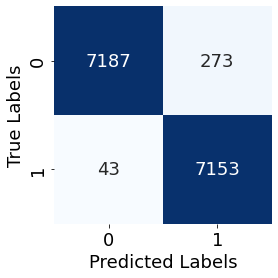

In [50]:
y_pred_ds = gnb_ds.predict(X_test)
print(classification_report(y_test, y_pred_ds))

conf_mat = confusion_matrix(y_test, y_pred_ds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

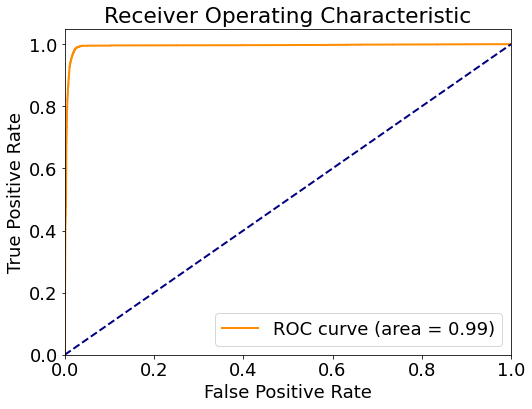

In [51]:
y_probs = gnb_ds.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

In [52]:
logistic_regression_ds = LogisticRegression(dual=False , random_state = 12345, max_iter=1000)
logistic_regression_ds.fit(X_train , y_train)

accuracy_lr_ds = cross_val_score(logistic_regression_ds , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lr_ds = cross_val_score(logistic_regression_ds , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lr_ds = cross_val_score(logistic_regression_ds , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lr_ds = cross_val_score(logistic_regression_ds , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lr_ds = cross_val_score(logistic_regression_ds , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_logistic_reg_ds = pd.DataFrame({
    "Accuracy" : accuracy_lr_ds, 
    "Precision": precision_lr_ds,
    "Recall" : recall_lr_ds, 
    "f1Score" : f1_lr_ds,
    "ROCAUC" : roc_auc_lr_ds
})

result_logistic_reg_ds

,Accuracy,Precision,Recall,f1Score,ROCAUC
0,0.634371,0.639319,0.625489,0.628027,0.687737
1,0.638038,0.631777,0.637686,0.631095,0.690170
2,0.637581,0.644631,0.627228,0.635943,0.696889
3,0.630672,0.644847,0.614501,0.631507,0.691245
4,0.635960,0.636808,0.629319,0.639634,0.689693


              precision    recall  f1-score   support

           0       0.65      0.64      0.64      7460
           1       0.63      0.63      0.63      7196

    accuracy                           0.64     14656
   macro avg       0.64      0.64      0.64     14656
weighted avg       0.64      0.64      0.64     14656



Text(83.68, 0.5, 'True Labels')

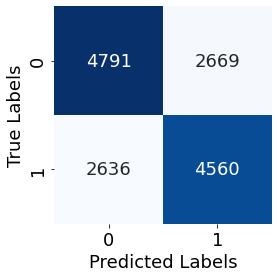

In [53]:
y_pred_ds = logistic_regression_ds.predict(X_test)
print(classification_report(y_test, y_pred_ds))

conf_mat = confusion_matrix(y_test, y_pred_ds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

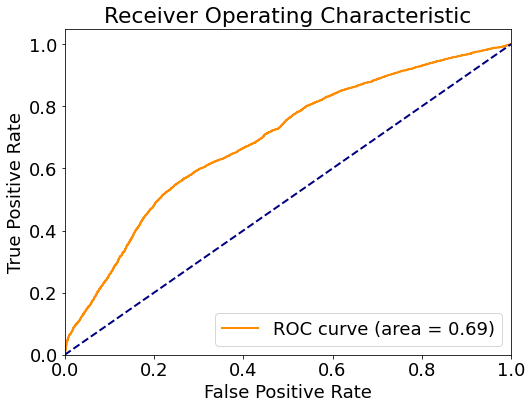

In [54]:
y_probs = logistic_regression_ds.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Downsampling seems to be a good approach in this case. The metrics has risen rapidly for Logistic Regression and improved a little in predicting minority class for Naive Bayes.  

Another reason might be high dimensionality of the data. PCA can be a good choice to find the principal components and decrease dimensionality. However, when it was utilized, the results not only got worse for the minority class, also decreased the overall accuracy by also getting worse at predicting the negative samples. So this method was not used in the rest of the project.  

Let's try different models that might work better and then reduce dimensionality by using the most important features only.  

### Random Forest Classifier

In [55]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train , y_train)

accuracy_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_random_forest = pd.DataFrame({
    "Accuracy" : accuracy_rf, 
    "Precision": precision_rf,
    "Recall" : recall_rf, 
    "f1Score" : f1_rf,
    "ROCAUC" : roc_auc_rf
})

result_random_forest

,Accuracy,Precision,Recall,f1Score,ROCAUC
0,0.999744,1.00000,0.999318,0.999578,1.0
1,0.999659,1.00000,0.999831,0.999915,1.0
2,0.999915,1.00000,0.998801,0.999916,1.0
3,0.999659,1.00000,0.999831,0.999828,1.0
4,0.999829,0.99983,0.999831,0.999744,1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7460
           1       1.00      1.00      1.00      7196

    accuracy                           1.00     14656
   macro avg       1.00      1.00      1.00     14656
weighted avg       1.00      1.00      1.00     14656



Text(83.68, 0.5, 'True Labels')

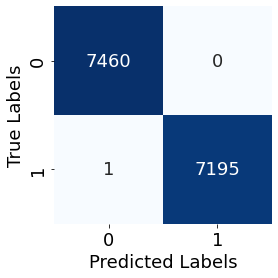

In [56]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

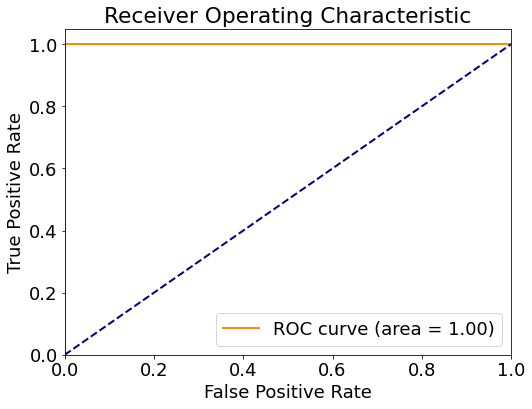

In [57]:
y_probs = random_forest.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machine (SVM)

In [58]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_train)

accuracy_svm = cross_val_score(svm , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_svm = cross_val_score(svm , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_svm = cross_val_score(svm , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_svm = cross_val_score(svm , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_svm = cross_val_score(svm , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_svm = pd.DataFrame({
    "Accuracy" : accuracy_svm, 
    "Precision": precision_svm,
    "Recall" : recall_svm, 
    "f1Score" : f1_svm,
    "ROCAUC" : roc_auc_svm
})

result_svm

,Accuracy,Precision,Recall,f1Score,ROCAUC
0,0.939446,0.898445,0.994042,0.940806,0.991538
1,0.942260,0.895273,0.996466,0.940571,0.991624
2,0.937564,0.897545,0.992872,0.942114,0.991278
3,0.936540,0.897219,0.994331,0.943363,0.991175
4,0.940379,0.891575,0.993913,0.945505,0.992001


              precision    recall  f1-score   support

           0       1.00      0.88      0.93      7460
           1       0.89      1.00      0.94      7196

    accuracy                           0.93     14656
   macro avg       0.94      0.94      0.93     14656
weighted avg       0.94      0.93      0.93     14656



Text(83.68, 0.5, 'True Labels')

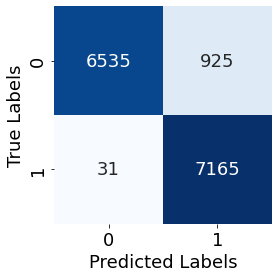

In [59]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

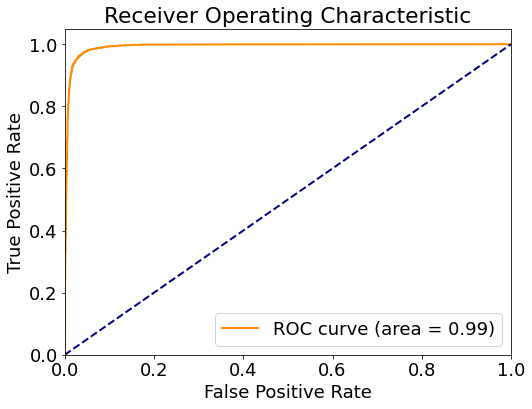

In [60]:
y_probs = svm.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### K-Nearest Neighbors Classifier

In [61]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

knn_preds = knn.predict(X_train)

accuracy_knn = cross_val_score(knn , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_knn = cross_val_score(knn , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_knn = cross_val_score(knn , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_knn = cross_val_score(knn , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_knn = cross_val_score(knn , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_knn = pd.DataFrame({
    "Accuracy" : accuracy_knn, 
    "Precision": precision_knn,
    "Recall" : recall_knn, 
    "f1Score" : f1_knn,
    "ROCAUC" : roc_auc_knn
})

result_knn

,Accuracy,Precision,Recall,f1Score,ROCAUC
0,0.874797,0.823830,0.946561,0.879028,0.940936
1,0.870448,0.824554,0.944736,0.882242,0.947599
2,0.870948,0.829771,0.948186,0.885835,0.942891
3,0.875128,0.829002,0.942655,0.880911,0.940976
4,0.872484,0.824688,0.944303,0.880529,0.945230


              precision    recall  f1-score   support

           0       0.94      0.80      0.87      7460
           1       0.82      0.95      0.88      7196

    accuracy                           0.88     14656
   macro avg       0.88      0.88      0.88     14656
weighted avg       0.89      0.88      0.88     14656



Text(83.68, 0.5, 'True Labels')

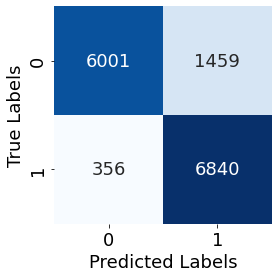

In [62]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

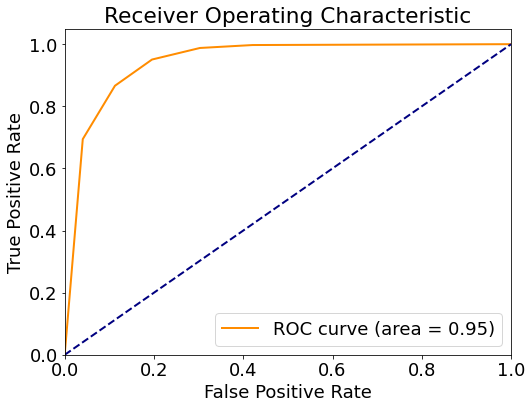

In [63]:
y_probs = knn.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Multi-Layer Perceptron (MLP) Classifier

In [64]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

mlp_preds = svm.predict(X_train)

accuracy_mlp = cross_val_score(mlp , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_mlp = cross_val_score(mlp , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_mlp = cross_val_score(mlp , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_mlp = cross_val_score(mlp , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_mlp = cross_val_score(mlp , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_mlp = pd.DataFrame({
    "Accuracy" : accuracy_mlp, 
    "Precision": precision_mlp,
    "Recall" : recall_mlp, 
    "f1Score" : f1_mlp,
    "ROCAUC" : roc_auc_mlp
})

result_mlp

,Accuracy,Precision,Recall,f1Score,ROCAUC
0,0.998806,0.998979,0.999830,0.999488,0.999639
1,0.999062,0.998987,0.999659,0.999575,0.999999
2,0.999659,0.998975,0.999831,0.999573,1.000000
3,0.999318,0.999142,0.998807,0.999492,0.999594
4,0.999318,0.998996,0.999325,0.999916,0.999988


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7460
           1       1.00      1.00      1.00      7196

    accuracy                           1.00     14656
   macro avg       1.00      1.00      1.00     14656
weighted avg       1.00      1.00      1.00     14656



Text(83.68, 0.5, 'True Labels')

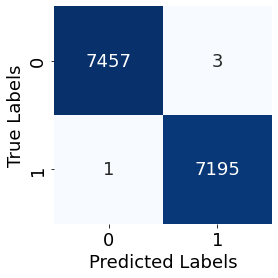

In [65]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

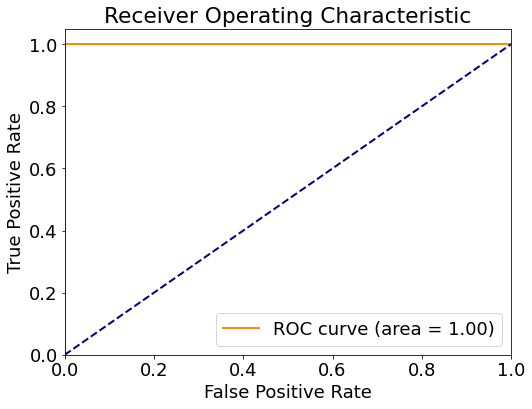

In [66]:
y_probs = mlp.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### XGBoost Classifier

In [67]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

accuracy_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_xgb = pd.DataFrame({
    "Accuracy" : accuracy_xgb,
    "Precision": precision_xgb,
    "Recall" : recall_xgb, 
    "f1Score" : f1_xgb,
    "ROCAUC" : roc_auc_xgb
})

result_xgb

,Accuracy,Precision,Recall,f1Score,ROCAUC
0,0.999829,1.000000,1.000000,0.999915,1.000000
1,1.000000,1.000000,0.999832,1.000000,0.999999
2,1.000000,0.999832,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,0.999915,1.000000
4,0.999915,0.999659,1.000000,0.999916,1.000000


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7460
           1       1.00      1.00      1.00      7196

    accuracy                           1.00     14656
   macro avg       1.00      1.00      1.00     14656
weighted avg       1.00      1.00      1.00     14656



Text(83.68, 0.5, 'True Labels')

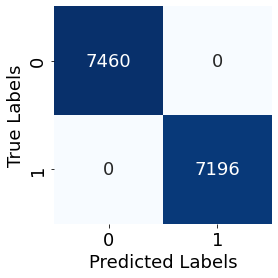

In [68]:
y_pred = xgboost.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

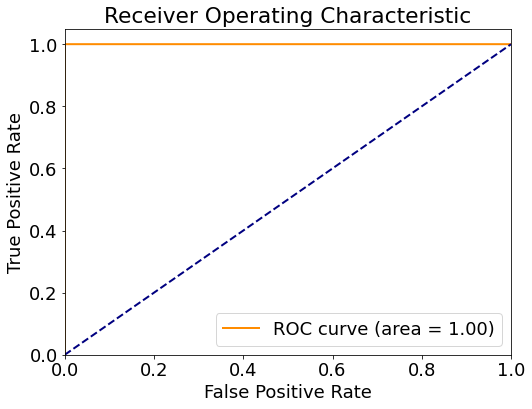

In [69]:
y_probs = xgboost.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

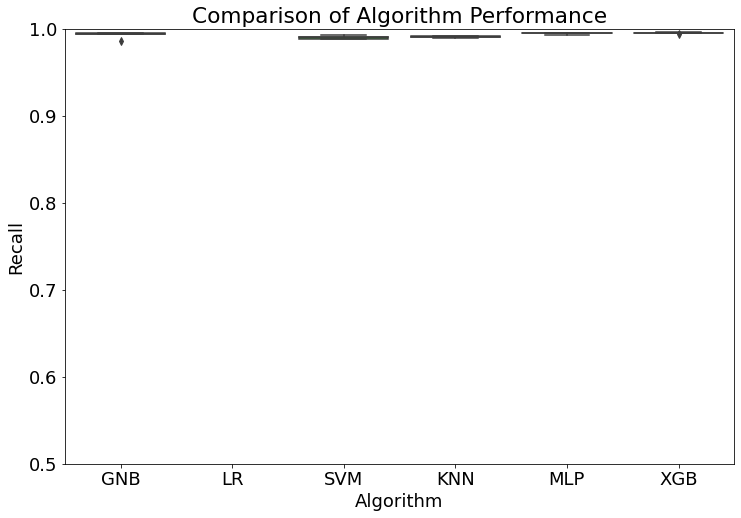

In [70]:
models = {
    "GNB": GaussianNB(),
    "LR": LogisticRegression(dual=False, max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(),
    "XGB": XGBClassifier()
}

results = {"Algorithm": [], "Score": []}

# Evaluate models
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='recall')
    results['Algorithm'].extend([name] * len(cv_scores))
    results['Score'].extend(cv_scores)

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x='Algorithm', y='Score', data=results_df)
boxplot.set_title('Comparison of Algorithm Performance')
boxplot.set_xlabel('Algorithm')
boxplot.set_ylabel('Recall')
plt.ylim(0.5, 1.0)
plt.show()

Now, let's find the most important features and reduce dimension to improve the results.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7460
           1       1.00      1.00      1.00      7196

    accuracy                           1.00     14656
   macro avg       1.00      1.00      1.00     14656
weighted avg       1.00      1.00      1.00     14656




,Feature,Importance
0,loan_amount,1.525130e-03
4,Credit_Score,8.628241e-04
5,LTV,8.891512e-05
2,Upfront_charges,4.185837e-05
3,term,1.668716e-05
1,rate_of_interest,7.808332e-08


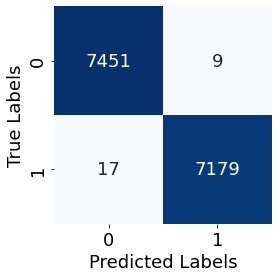

In [71]:
rf =RandomForestClassifier(max_features = None,
                            max_depth = 45,
                            min_samples_split = 3,
                            min_samples_leaf = 30,
                            random_state=42)

rf.fit(X_train, y_train)

results = list(zip(X, rf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

print()
importance

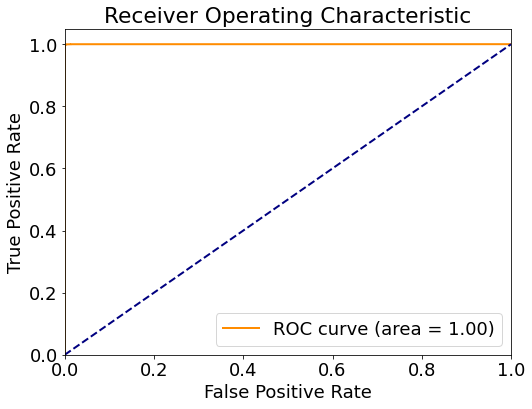

In [72]:
y_probs = rf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [73]:
data_downsampled.columns

Index(['Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Upfront_charges', 'term', 'Neg_ammortization', 'occupancy_type',
       'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Status'],
      dtype='object')

In [74]:
data2 = data_downsampled[['loan_amount', 'Credit_Score', 'LTV', 'term', 'Upfront_charges', 'rate_of_interest', 'Status']]
data2.head()

,loan_amount,Credit_Score,LTV,term,Upfront_charges,rate_of_interest,Status
20907,256500,565,95.708955,360.0,0.00,3.990,0
1156,216500,619,64.053254,240.0,108.33,3.625,0
137562,146500,603,82.303371,360.0,1445.00,4.990,0
146313,586500,530,80.563187,360.0,0.00,3.990,0
101844,166500,725,93.539326,360.0,2918.40,4.125,0


In [75]:
X = data2.drop(['Status'], axis=1)
y = data2['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

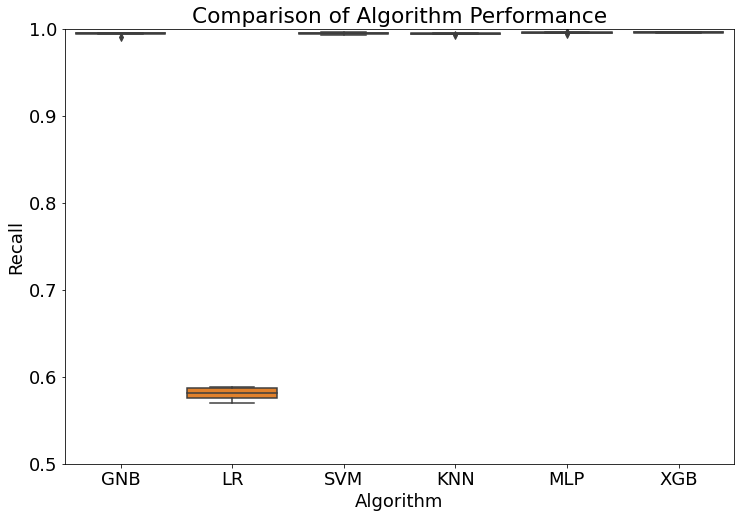

In [76]:
models = {
    "GNB": GaussianNB(),
    "LR": LogisticRegression(dual=False, max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(),
    "XGB": XGBClassifier()
}

results = {"Algorithm": [], "Score": []}

# Evaluate models
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='recall')
    results['Algorithm'].extend([name] * len(cv_scores))
    results['Score'].extend(cv_scores)

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x='Algorithm', y='Score', data=results_df)
boxplot.set_title('Comparison of Algorithm Performance')
boxplot.set_xlabel('Algorithm')
boxplot.set_ylabel('Recall')
plt.ylim(0.5, 1.0)
plt.show()

## Hyperparameter Tuning for the Best Model - XGB

In [77]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Setup the scorer
scorer = make_scorer(recall_score)

# Grid Search
grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring=scorer,
    n_jobs=-1,
    cv=5,
    verbose=3
)

grid_search.fit(X, y)
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best score found by GridSearchCV:", grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found by GridSearchCV: {'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8}
Best score found by GridSearchCV: 0.9962062275796345


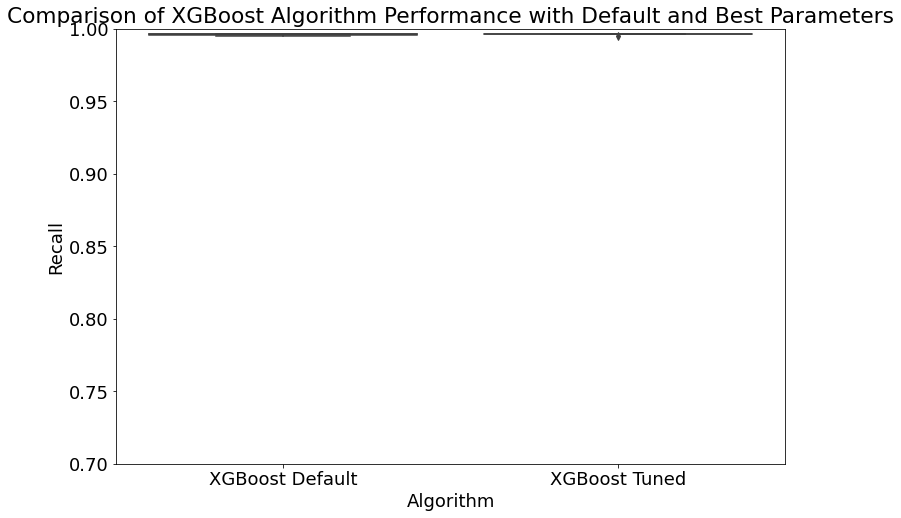

In [78]:
models = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost Tuned": XGBClassifier(**grid_search.best_params_)
}

results = {"Algorithm": [], "Score": []}

# Evaluate Models
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='recall')
    results['Algorithm'].extend([name] * len(cv_scores))
    results['Score'].extend(cv_scores)

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x='Algorithm', y='Score', data=results_df)
boxplot.set_title('Comparison of XGBoost Algorithm Performance with Default and Best Parameters')
boxplot.set_xlabel('Algorithm')
boxplot.set_ylabel('Recall')
plt.ylim(0.7, 1.0)
plt.show()

Classification Report for XGBoost Default:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7353
           1       1.00      1.00      1.00      7303

    accuracy                           1.00     14656
   macro avg       1.00      1.00      1.00     14656
weighted avg       1.00      1.00      1.00     14656

Classification Report for XGBoost Tuned:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7353
           1       1.00      1.00      1.00      7303

    accuracy                           1.00     14656
   macro avg       1.00      1.00      1.00     14656
weighted avg       1.00      1.00      1.00     14656



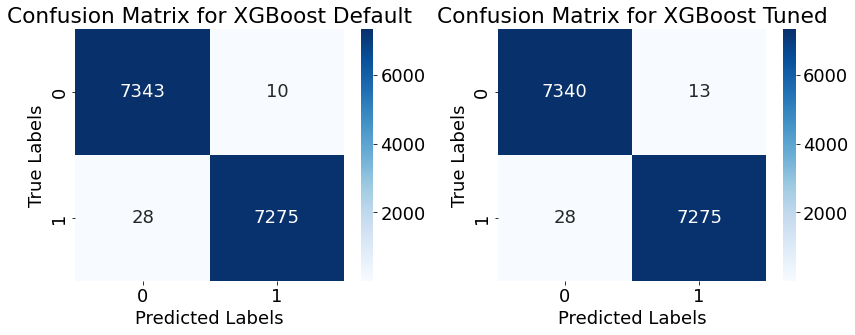

In [79]:
for name, model in models.items():
    # Create a pipeline with standard scaling and the model
    pipeline = make_pipeline(StandardScaler(), model)
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Print classification report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    print("="*60)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.flatten()

for i, (name, model) in enumerate(models.items()):
    # Create a pipeline and train the model
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix in a subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[i])
    ax[i].set_xlabel('Predicted Labels')
    ax[i].set_ylabel('True Labels')
    ax[i].set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()